In [65]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils
import RM_utils
import utilities.colormaps
import random
import string

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Computer Modern']})

In [32]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def initialize(letter_vecs, N, D, state_length=5, n_steps=500):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

def spell(coef_hists):
    pred = ''
    alphis = []

    for i in range(len(coef_hists)):
        x, alphi = np.unravel_index(coef_hists[i].argmax(), coef_hists[i].shape)
        pred += alph[alphi]
        alphis.append(alphi)

    return pred, alphis

def explain_away(bound_vec, states, coef_hists, state_length, letter_vecs, 
                 N, D, max_steps=500, conseq=100):
    th_vec = bound_vec.copy()
    conseq_preds = []
    convstep = -1

    for i in range(max_steps):

        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
        
        for j in range(1, state_length-1):
            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])
        ljds = []
        for j in range(1, state_length-1):
            if j == 1:
                ljds.append(
                    (np.roll(th_vec * states[0] * np.roll(states[2], 2), -1) +
                    th_vec * np.roll(states[2], 1) * np.roll(states[3], 2)) / 2
                )
            elif 1 < j < state_length-2:
                ljds.append(
                    (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
                )
            else:
                ljds.append(
                    (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2
                )

        for j in range(1, state_length-1):    
            states[j] = np.dot(letter_vecs.T, np.dot(ljds[j-1], letter_vecs.T)/N) + 1.0*states[j]
        
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2)  
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        th_vec = bound_vec - bv
        pred, alphis = spell(coef_hists)
        
        if convstep == -1:
            if len(conseq_preds) == conseq and len( set( conseq_preds ) ) == 1:
                convstep = i
                #break
            conseq_preds.append(pred)
            conseq_preds = conseq_preds[-conseq:]

#         print ('pred', pred)
#     print ('conseq', conseq_preds, len(conseq_preds))
#     print ('breaked', i, convstep)

    return states, coef_hists, convstep
    
def resplot(word_length, states, coef_hists, N, nsteps, start):
    
    pred, alphis = spell(coef_hists)
    print pred
    rows = 1
    columns = word_length

    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(25,5))
    cols = get_cmap('copper', min(500,n_steps))
    x = np.linspace(0,len(alph)-2,len(alph)-2)
    labels = list(alph)
    plt.xticks(x, labels)
    
    for j in range(word_length):
        for i in range(start, min(500,n_steps)):
            # graphing the max positive at every iteration is not intuitive, since we should
            # be focusing on how our predicted letter's probability increases over time
            coef_hists[j][i,alphis[j]] = np.abs(coef_hists[j][i,alphis[j]])
            axes[j].plot(coef_hists[j][i,:], lw=1.7, c=cols(i))
            
        step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        axes[j].plot(alphi, coef_hists[j][step, alphi], '+')

    #plt.savefig('figures/'+title+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-reg='+reg+'.svg')
    
def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))


In [23]:
# 1
alph = 'abcdefghijklmnopqrstuvwxyz#.'
D = len(alph)

accs = []
binaccs = []
convsteps = []

convaccs = []
convbinaccs = []

N = 1000
n_steps = 500
trials = 100

# N-neurons
for i in range(6):
    N = 1000*(2**i)
    dic1 = 2 * (np.random.randn(D, N) < 0) - 1
    accs.append([])
    binaccs.append([])
    convsteps.append([])
    convaccs.append([])
    convbinaccs.append([])
    print ('N', N)

    # M-letter word
    for word_length in range(2,22,2):
        print ('word_length', word_length)
        avg_per_acc = []
        avg_bin_acc = []
        avg_conv_steps = []
        avg_conv_per_acc = []
        avg_conv_bin_acc = []

        # average results
        for trial in range(trials):
            word = ''.join(random.choice(string.lowercase) for j in range(word_length))
            word_vec = ngram_encode_cl(word, dic1, alph)

            states, coef_hists = initialize(dic1, N, D, word_length+2, n_steps)
            states, coef_hists, steps = explain_away(
                word_vec, states, coef_hists, word_length+2, dic1, N, D, n_steps)

            conv_coef_hists = [coef_hists[j][:steps] for j in range(len(coef_hists))]
            pred, alphis = spell(coef_hists)
            predconv, alphisconv = spell(conv_coef_hists)
            #print (pred, predconv, word, steps)
            avg_per_acc.append(accuracy(pred, word))
            avg_bin_acc.append(1 if pred == word else 0)

            if steps != -1:
                avg_conv_steps.append(steps)
                avg_conv_per_acc.append(accuracy(predconv, word))
                avg_conv_bin_acc.append(1 if predconv == word else 0)

        accs[i].append( np.average(avg_per_acc))
        binaccs[i].append( np.average(avg_bin_acc))
        
        if len(avg_conv_steps) > 0:
            convsteps[i].append( np.average(avg_conv_steps))
            convaccs[i].append( np.average(avg_conv_per_acc))
            convbinaccs[i].append( np.average(avg_conv_bin_acc))
        #print ('word_length', word_length, accs[sigma][i], binaccs[sigma][i], convsteps[sigma][i])

('N', 1000)
('word_length', 2)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: overflow encountered in m

('word_length', 4)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in multiply


('word_length', 6)
('word_length', 8)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in add


('word_length', 10)
('word_length', 12)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in add


('word_length', 14)
('word_length', 16)
('word_length', 18)
('word_length', 20)
('N', 2000)
('word_length', 2)
('word_length', 4)
('word_length', 6)
('word_length', 8)
('word_length', 10)
('word_length', 12)
('word_length', 14)
('word_length', 16)
('word_length', 18)
('word_length', 20)
('N', 4000)
('word_length', 2)
('word_length', 4)
('word_length', 6)
('word_length', 8)
('word_length', 10)
('word_length', 12)
('word_length', 14)
('word_length', 16)
('word_length', 18)
('word_length', 20)
('N', 8000)
('word_length', 2)
('word_length', 4)
('word_length', 6)
('word_length', 8)
('word_length', 10)
('word_length', 12)
('word_length', 14)
('word_length', 16)
('word_length', 18)
('word_length', 20)
('N', 16000)
('word_length', 2)
('word_length', 4)
('word_length', 6)
('word_length', 8)
('word_length', 10)
('word_length', 12)
('word_length', 14)
('word_length', 16)
('word_length', 18)
('word_length', 20)


KeyboardInterrupt: 

In [24]:
fname = ('data/res_word_trigram-04-06-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d%H%M%S') + '.npz')

np.savez(fname, accs=accs, binaccs=binaccs, convsteps=convsteps, convaccs=convaccs, convbinaccs=convbinaccs, N=N, D=D)


In [27]:
f = np.load('data/res_word_trigram-04-06-2018-N=16000-D=28-n180407225159.npz')

In [28]:
accs = f['accs']
binaccs = f['binaccs']
convsteps = f['convsteps']

convaccs = f['convaccs']
convbinaccs = f['convbinaccs']

In [33]:
# fill up word lengths
print (len(accs[3]), len(accs[4]))
i = 4
N = 1000*(2**i)
# M-letter word
for word_length in range(20,22,2):
    print ('word_length', word_length)
    avg_per_acc = []
    avg_bin_acc = []
    avg_conv_steps = []
    avg_conv_per_acc = []
    avg_conv_bin_acc = []

    # average results
    for trial in range(trials):
        word = ''.join(random.choice(string.lowercase) for j in range(word_length))
        word_vec = ngram_encode_cl(word, dic1, alph)

        states, coef_hists = initialize(dic1, N, D, word_length+2, n_steps)
        states, coef_hists, steps = explain_away(
            word_vec, states, coef_hists, word_length+2, dic1, N, D, n_steps)

        conv_coef_hists = [coef_hists[j][:steps] for j in range(len(coef_hists))]
        pred, alphis = spell(coef_hists)
        predconv, alphisconv = spell(conv_coef_hists)
        #print (pred, predconv, word, steps)
        avg_per_acc.append(accuracy(pred, word))
        avg_bin_acc.append(1 if pred == word else 0)

        if steps != -1:
            avg_conv_steps.append(steps)
            avg_conv_per_acc.append(accuracy(predconv, word))
            avg_conv_bin_acc.append(1 if predconv == word else 0)

    accs[i].append( np.average(avg_per_acc))
    binaccs[i].append( np.average(avg_bin_acc))

    if len(avg_conv_steps) > 0:
        convsteps[i].append( np.average(avg_conv_steps))
        convaccs[i].append( np.average(avg_conv_per_acc))
        convbinaccs[i].append( np.average(avg_conv_bin_acc))
    #print ('word_length', word_length, accs[sigma][i], binaccs[sigma][i], convsteps[sigma][i])

(10, 9)
('word_length', 20)


In [37]:
print len(accs)
print len(binaccs)
print len(convsteps)
print len(convaccs)
print len(convbinaccs)
print type(accs)

accs = list(accs)
binaccs = list(binaccs)
convsteps = list(convsteps)
convaccs = list(convaccs)
convbinaccs = list(convbinaccs)


5
5
5
5
5
<type 'numpy.ndarray'>


In [ ]:
N = 1000
n_steps = 500
trials = 100

# N-neurons
for i in range(5,6):
    N = 1000*(2**i)
    dic1 = 2 * (np.random.randn(D, N) < 0) - 1
    accs.append([])
    binaccs.append([])
    convsteps.append([])
    convaccs.append([])
    convbinaccs.append([])
    print ('N', N)

    # M-letter word
    for word_length in range(2,22,2):
        print ('word_length', word_length)
        avg_per_acc = []
        avg_bin_acc = []
        avg_conv_steps = []
        avg_conv_per_acc = []
        avg_conv_bin_acc = []

        # average results
        for trial in range(trials):
            word = ''.join(random.choice(string.lowercase) for j in range(word_length))
            word_vec = ngram_encode_cl(word, dic1, alph)

            states, coef_hists = initialize(dic1, N, D, word_length+2, n_steps)
            states, coef_hists, steps = explain_away(
                word_vec, states, coef_hists, word_length+2, dic1, N, D, n_steps)

            conv_coef_hists = [coef_hists[j][:steps] for j in range(len(coef_hists))]
            pred, alphis = spell(coef_hists)
            predconv, alphisconv = spell(conv_coef_hists)
            #print (pred, predconv, word, steps)
            avg_per_acc.append(accuracy(pred, word))
            avg_bin_acc.append(1 if pred == word else 0)

            if steps != -1:
                avg_conv_steps.append(steps)
                avg_conv_per_acc.append(accuracy(predconv, word))
                avg_conv_bin_acc.append(1 if predconv == word else 0)

        accs[i].append( np.average(avg_per_acc))
        binaccs[i].append( np.average(avg_bin_acc))
        
        if len(avg_conv_steps) > 0:
            convsteps[i].append( np.average(avg_conv_steps))
            convaccs[i].append( np.average(avg_conv_per_acc))
            convbinaccs[i].append( np.average(avg_conv_bin_acc))
        #print ('word_length', word_length, accs[sigma][i], binaccs[sigma][i], convsteps[sigma][i])

('N', 32000)
('word_length', 2)
('word_length', 4)
('word_length', 6)
('word_length', 8)
('word_length', 14)
('word_length', 16)
('word_length', 18)
('word_length', 20)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in add


In [39]:
fname = ('data/res_word_trigram-04-06-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d%H%M%S') + '.npz')

np.savez(fname, accs=accs, binaccs=binaccs, convsteps=convsteps, convaccs=convaccs, convbinaccs=convbinaccs, N=N, D=D)


In [49]:
f = np.load('data/res_word_trigram-04-06-2018-N=32000-D=28-n180409000945.npz')

In [50]:
accs = f['accs']
binaccs = f['binaccs']
convsteps = f['convsteps']

convaccs = f['convaccs']
convbinaccs = f['convbinaccs']

In [51]:
print len(accs[5])

9


In [ ]:
# fill up word lengths
print (len(accs[3]), len(accs[4]))
i = 5
N = 1000*(2**i)
# M-letter word
for word_length in range(20,22,2):
    print ('word_length', word_length)
    avg_per_acc = []
    avg_bin_acc = []
    avg_conv_steps = []
    avg_conv_per_acc = []
    avg_conv_bin_acc = []

    # average results
    for trial in range(trials):
        word = ''.join(random.choice(string.lowercase) for j in range(word_length))
        word_vec = ngram_encode_cl(word, dic1, alph)

        states, coef_hists = initialize(dic1, N, D, word_length+2, n_steps)
        states, coef_hists, steps = explain_away(
            word_vec, states, coef_hists, word_length+2, dic1, N, D, n_steps)

        conv_coef_hists = [coef_hists[j][:steps] for j in range(len(coef_hists))]
        pred, alphis = spell(coef_hists)
        predconv, alphisconv = spell(conv_coef_hists)
        #print (pred, predconv, word, steps)
        avg_per_acc.append(accuracy(pred, word))
        avg_bin_acc.append(1 if pred == word else 0)

        if steps != -1:
            avg_conv_steps.append(steps)
            avg_conv_per_acc.append(accuracy(predconv, word))
            avg_conv_bin_acc.append(1 if predconv == word else 0)

    accs[i].append( np.average(avg_per_acc))
    binaccs[i].append( np.average(avg_bin_acc))

    if len(avg_conv_steps) > 0:
        convsteps[i].append( np.average(avg_conv_steps))
        convaccs[i].append( np.average(avg_conv_per_acc))
        convbinaccs[i].append( np.average(avg_conv_bin_acc))
    #print ('word_length', word_length, accs[sigma][i], binaccs[sigma][i], convsteps[sigma][i])

(10, 10)
('word_length', 20)


In [55]:
fname = ('data/res_word_trigram-04-06-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d%H%M%S') + '.npz')

np.savez(fname, accs=accs, binaccs=binaccs, convsteps=convsteps, convaccs=convaccs, convbinaccs=convbinaccs, N=N, D=D)


In [ ]:
##### GRAPHING #####

In [57]:
print len(accs)

6


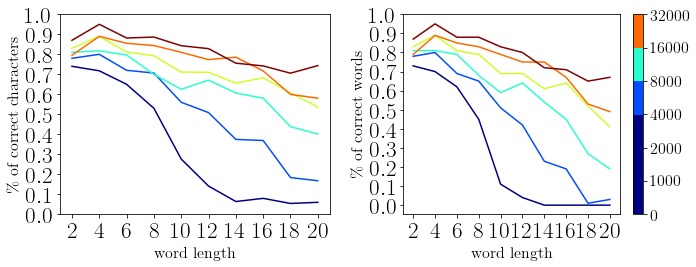

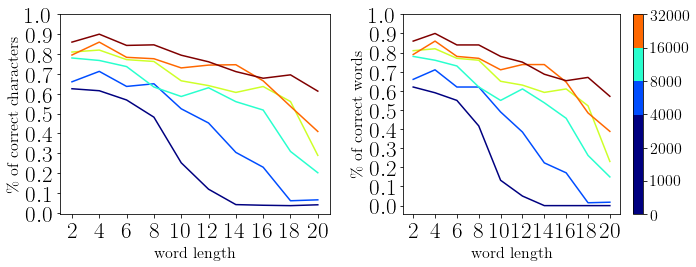

In [87]:
def plot_accs(accs, binaccs, conv='False'):
    rows = 1
    columns = 2
    test_N = [1000*(2**i) for i in range(len(accs))]
    numN = len(test_N)

    cols = get_cmap("jet", numN)

    xaxis = [i for i in range(2,22,2)]
    yaxis = [i*.1 for i in range(11)]
    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(10,4))


    for k in range(numN):
        axes[0].plot(xaxis, accs[k], c=cols(k))
        axes[1].plot(xaxis, binaccs[k], c=cols(k))
        
    axes[0].set_xlabel('word length', fontsize=16)
    axes[0].set_ylabel('\% of correct characters', fontsize=16)
    axes[0].set_xticks(xaxis)
    axes[0].set_yticks(yaxis)
    
    axes[1].set_xlabel('word length', fontsize=16)
    axes[1].set_ylabel('\% of correct words', fontsize=16)
    axes[1].set_xticks(xaxis)
    axes[1].set_yticks(yaxis)

    sm = plt.cm.ScalarMappable(cmap=cols)#, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    cbar = fig.colorbar(sm, boundaries=[0] + test_N)
    cbar.ax.tick_params(labelsize=16) 
    
    plt.tight_layout()
    plt.show()
    plt.savefig('figures/04-06-2018/res_word_trigram-04-06-2018-1a-iters=500conv=' + conv + time.strftime('%y%m%d%H%M%S') + '.eps', 
                format='eps', dpi=1000)
    plt.savefig('figures/04-06-2018/res_word_trigram-04-06-2018-1a-iters=500conv=' + conv + time.strftime('%y%m%d%H%M%S') + '.png', 
                format='png', transparent=True)

    
plot_accs(accs, binaccs, conv='False')
plot_accs(convaccs, convbinaccs, conv='True')

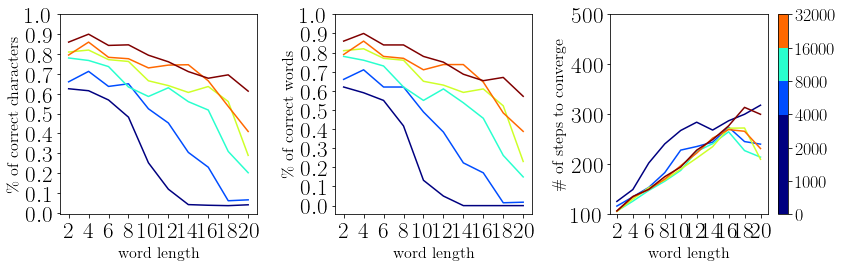

In [88]:
def plot_accs_steps(accs, binaccs, steps):
    rows = 1
    columns = 3
    test_N = [1000*(2**i) for i in range(len(accs))]
    numN = len(test_N)

    cols = get_cmap("jet", numN)

    xaxis = [i for i in range(2,22,2)]
    yaxis = [i*.1 for i in range(11)]
    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(12,4))

    for k in range(numN):
        axes[0].plot(xaxis, accs[k], c=cols(k))
        axes[1].plot(xaxis, binaccs[k], c=cols(k))
        axes[2].plot(xaxis, steps[k], c=cols(k))

    axes[0].set_xlabel('word length', fontsize=16)
    axes[0].set_ylabel('\% of correct characters', fontsize=16)
    axes[0].set_xticks(xaxis)
    axes[0].set_yticks(yaxis)
    
    axes[1].set_xlabel('word length', fontsize=16)
    axes[1].set_ylabel('\% of correct words', fontsize=16)
    axes[1].set_xticks(xaxis)
    axes[1].set_yticks(yaxis)

    axes[2].set_xlabel('word length', fontsize=16)
    axes[2].set_ylabel('\# of steps to converge', fontsize=16)
    axes[2].set_ylim(100, 500)
    axes[2].set_xticks(xaxis)
    
    sm = plt.cm.ScalarMappable(cmap=cols)#, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    cbar = fig.colorbar(sm, boundaries=[0] + test_N)
    cbar.ax.tick_params(labelsize=18) 
    plt.tight_layout()
    plt.show()
    plt.savefig('figures/04-06-2018/res_word_trigram-04-06-2018-1b-iters=500' + time.strftime('%y%m%d%H%M%S') + '.eps', 
                format='eps', dpi=1000)
    plt.savefig('figures/04-06-2018/res_word_trigram-04-06-2018-1b-iters=500=' + time.strftime('%y%m%d%H%M%S') + '.png', 
                format='png', transparent=True)

plot_accs_steps(convaccs, convbinaccs, convsteps)